In [1]:
# import libraries
import ast
from collections import Counter
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
import pandas as pd
from pylab import rcParams
import random
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
# from sklearn.metrics import f1_score
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from tqdm import tqdm
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup


%matplotlib inline

%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 10
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained("hfl/chinese-roberta-wwm-ext", do_lower_case=True)
PRE_TRAINED_MODEL_NAME = '/home/jovyan/graph-stock-pred/Astock/models/ROBERT_4_model'


### Dataset
- load data from multi-stocks

In [2]:
from glob import glob

paths = glob("/home/jovyan/graph-stock-pred/Astock/data/pre/transformed/*-transformed.csv")
df = pd.DataFrame()
for path in tqdm(paths):
    df = pd.concat([df, pd.read_csv(path)])
df.head()
df.info()

100%|██████████| 35/35 [00:00<00:00, 67.28it/s]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 38187 entries, 0 to 1090
Data columns (total 33 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          38187 non-null  object 
 1   open          38185 non-null  float64
 2   high          38185 non-null  float64
 3   low           38185 non-null  float64
 4   close         38185 non-null  float64
 5   close_next    38150 non-null  float64
 6   change_next   38148 non-null  float64
 7   pct_chg_next  38148 non-null  float64
 8   ADX           35871 non-null  float64
 9   MACD          35661 non-null  float64
 10  MACDsignal    35661 non-null  float64
 11  MACDhist      35661 non-null  float64
 12  RSI           36326 non-null  float64
 13  ATR           36326 non-null  float64
 14  OBV           38187 non-null  float64
 15  BETA          36641 non-null  float64
 16  upperBAND     36676 non-null  float64
 17  middleBAND    36676 non-null  float64
 18  lowerBAND     36676 non-nul

- split train, val, test, ood datasets by date


In [3]:
# train: 80% from 2018.07 - 2021.12 
# val: 10% from 2018.07 - 2021.12 
# test: 10% from 2018.07 - 2021.12 
# ood: 2022.01 - 2022.06

df_train = df[df["date"]<"2022-01-01"].reset_index(drop=True)
df_ood = df[(df["date"]>="2022-01-01") & (df["date"]<"2022-07-01")].reset_index(drop=True)

df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_test.sample(frac=0.5)
df_test = df_test.drop(df_val.index)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print(df_train.shape, df_val.shape, df_test.shape, df_ood.shape)

(27274, 33) (3409, 33) (3409, 33) (4095, 33)


In [4]:
# train: 2018.07 - 2021.06
df_train = df[df["date"]<"2021-07-01"].reset_index(drop=True)
# val: 2021.07 - 2021.09
df_val = df[(df["date"]>="2021-07-01") & (df["date"]<"2021-10-01")].reset_index(drop=True)
# test: 2021.10 - 2021.12
df_test = df[(df["date"]>="2021-10-01") & (df["date"]<"2022-01-01")].reset_index(drop=True)
# ood: 2022.01 - 2022.06
df_ood = df[(df["date"]>="2022-01-01") & (df["date"]<"2022-07-01")].reset_index(drop=True)

print(df_train.shape, df_val.shape, df_test.shape, df_ood.shape)

(29612, 33) (2240, 33) (2240, 33) (4095, 33)


- compute `label` column from `pct_chg_next` 
    - Thesis uses: $(close - pre close) / close$, but stock price change should devide by previous price. We corrected here
- We uese `qcut` and the distribution of `pct_chg_next` between 2018/07/02 - 2022/06/30 is: 
    ```
        (-0.0686, -0.00503]    325
        (0.0069, 0.0997]       325
        (-0.00503, 0.0069]     324
    ```
- Then filter out days with no news

In [5]:
def gen_label(df):
    df["label"] = pd.qcut(df['pct_chg_next'], q=3, labels=[0,1,2])
    return df


df_train = gen_label(df=df_train)
df_val = gen_label(df=df_val)
df_test = gen_label(df=df_test)
df_ood = gen_label(df=df_ood)

df_train = df_train[df_train.titles.notnull()].reset_index(drop=True)
df_val = df_val[df_val.titles.notnull()].reset_index(drop=True)
df_test = df_test[df_test.titles.notnull()].reset_index(drop=True)
df_ood = df_ood[df_ood.titles.notnull()].reset_index(drop=True)

print(df_train.shape, df_val.shape, df_test.shape, df_ood.shape)


(7921, 34) (1456, 34) (1394, 34) (2270, 34)


In [6]:
df_train[["pct_chg_next","label"]].describe(), df_val[["pct_chg_next","label"]].describe(), df_test[["pct_chg_next","label"]].describe()
df_ood[["pct_chg_next","label"]].describe()

,pct_chg_next
count,2270.000000
mean,-0.000029
std,0.026163
min,-0.099099
25%,-0.013070
50%,0.000000
75%,0.011400
max,0.100000


- compute verb-A0-A1 triplets number as `AV_num`

In [7]:
df_train["AV_num"] = df_train["verbA0A1"].apply(lambda x: len(eval(x)))
df_val["AV_num"] = df_val["verbA0A1"].apply(lambda x: len(eval(x)))
df_test["AV_num"] = df_test["verbA0A1"].apply(lambda x: len(eval(x)))
df_ood["AV_num"] = df_ood["verbA0A1"].apply(lambda x: len(eval(x)))

In [8]:
df_train

,date,open,high,low,close,close_next,change_next,pct_chg_next,ADX,MACD,...,trade_date,news_count,titles,verbA0A1,verb,A0,A1,stock_id,label,AV_num
0,2018-01-10,9.606958,9.606958,9.568221,9.606958,9.606958,0.000000,0.000000,NaN,NaN,...,2018-01-10,1.0,友达将于2月7日召开在线法人说明会,"[[[(8, 2)], [(0, 2)], [(10, 7)]]]","[(8, 2)]","[(0, 2)]","[(10, 7)]",2409,1,1
1,2018-01-29,11.156468,11.195205,11.001517,11.040255,10.691615,-0.348639,-0.031579,NaN,NaN,...,2018-01-29,1.0,友达订购生产设备,"[[[(2, 2)], [(0, 2)], [(4, 4)]]]","[(2, 2)]","[(0, 2)]","[(4, 4)]",2409,0,1
2,2018-02-06,10.149287,10.188024,9.684434,9.916861,10.304238,0.387378,0.039063,NaN,NaN,...,2018-02-06,4.0,友达法人说明会之财务与业务信息。友达董事会核准捐赠明基友达文教基金会办理文化教育之推动。友达...,"[[[(21, 2)], [(16, 5)], [(23, 20)]], [[(34, 2)...","[(21, 2), (34, 2), (49, 2), (61, 2)]","[(16, 5), (25, 9), (44, 5), (59, 2)]","[(23, 20), (36, 4), (52, 6), (63, 7)]",2409,2,4
3,2018-02-12,10.381713,10.420451,10.149287,10.149287,10.381713,0.232426,0.022901,34.444635,NaN,...,2018-02-12,1.0,友达高端主管人事,"[[[(4, 2)], [(0, 4)], [(6, 2)]]]","[(4, 2)]","[(0, 4)]","[(6, 2)]",2409,2,1
4,2018-03-20,10.691615,10.924042,10.652878,10.846566,10.730353,-0.116213,-0.010714,20.993331,0.134537,...,2018-03-20,1.0,友达将参加Credit Suisse举办之Credit SuisseAsianInvestm...,"[[[(3, 2)], [(0, 2)], [(5, 16)]]]","[(3, 2)]","[(0, 2)]","[(5, 16)]",2409,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7916,2021-06-10,12.962687,13.058707,12.530597,12.914677,12.914677,0.000000,0.000000,19.093158,0.122793,...,2021-06-10,2.0,外资近5日买超个股。外资近3日买超个股,"[[[(5, 1)], [(0, 2)], [(6, 3)]], [[(15, 1)], [...","[(5, 1), (15, 1)]","[(0, 2), (10, 2)]","[(6, 3), (16, 3)]",1314,1,2
7917,2021-06-16,12.962686,13.346766,12.866666,13.010696,12.914677,-0.096020,-0.007380,15.855273,0.083264,...,2021-06-16,7.0,盘前财经大事抢先读2021年06月17日。〈台股盘前要闻〉国巨订单能见度达3年、台积电发债1...,"[[[(38, 2)], [(35, 3)], [(40, 3)]], [[(55, 1)]...","[(38, 2), (55, 1), (86, 2), (127, 2), (219, 2)...","[(35, 3), (52, 3), (80, 6), (113, 14), (213, 6...","[(40, 3), (56, 5), (88, 23), (129, 38), (221, ...",1314,0,6
7918,2021-06-22,12.674626,13.058706,12.626616,13.058706,12.866666,-0.192040,-0.014706,13.305096,0.012381,...,2021-06-22,2.0,外资近5日买超个股。外资近3日买超个股,"[[[(5, 1)], [(0, 2)], [(6, 3)]], [[(15, 1)], [...","[(5, 1), (15, 1)]","[(0, 2), (10, 2)]","[(6, 3), (16, 3)]",1314,0,2
7919,2021-06-23,13.250746,13.298756,12.674626,12.866666,13.010696,0.144031,0.011194,12.611027,0.013328,...,2021-06-23,3.0,产品利差维持高档中石化Q2EPS可望攀近11季新高。外资近5日卖超个股。外资近3日卖超个股,"[[[(16, 1)], [(0, 14)], [(17, 5)]], [[(28, 1)]...","[(16, 1), (28, 1), (38, 1)]","[(0, 14), (23, 2), (33, 2)]","[(17, 5), (29, 3), (39, 3)]",1314,2,3


- merge `stock_factors` to array in one column

Now each sample will have these factors: 
```
    open             206.536808
    high             206.536808
    low              202.929178
    close            203.831085
    ADX               23.221764
    MACD              -2.980201
    MACDsignal        -3.282814
    MACDhist           0.302614
    RSI               39.912134
    ATR                4.694009
    OBV             474889350.0
    BETA               0.956859
    upperBAND        210.204452
    middleBAND       206.446628
    lowerBAND        202.688804
    成交股數             47138909.0
    成交筆數                16009.0
    成交金額          10696822542.0
    殖利率(%)                 3.54
    本益比                   16.72
    股價淨值比                  3.72
    news_count              2.0
```

In [9]:
# remove nan rows
factor_cols = ["open","high","low","close","ADX","MACD","MACDsignal","MACDhist","RSI","ATR","OBV","BETA","upperBAND","middleBAND","lowerBAND","成交股數","成交筆數","成交金額","殖利率(%)","本益比","股價淨值比","news_count"]
for col in tqdm(factor_cols):
    df_train = df_train[df_train[col].notnull()].reset_index(drop=True)
    df_val = df_val[df_val[col].notnull()].reset_index(drop=True)
    df_test = df_test[df_test[col].notnull()].reset_index(drop=True)
    df_ood = df_ood[df_ood[col].notnull()].reset_index(drop=True)


# Normalization all factors to the same scale
standard_scaler = StandardScaler()
# 1. fit from training set
standard_scaler.fit(df_train[factor_cols])
# 2. transform train, val, test, ood sets, since stock factors are used in training feature, if we don't know future price, we can't normalize it with the future time duration
df_train[factor_cols] = standard_scaler.transform(df_train[factor_cols])
df_val[factor_cols] = standard_scaler.transform(df_val[factor_cols])
df_test[factor_cols] = standard_scaler.transform(df_test[factor_cols])
df_ood[factor_cols] = standard_scaler.transform(df_ood[factor_cols])


100%|██████████| 22/22 [00:00<00:00, 212.96it/s]


In [10]:
# disbutions of stock factors have huge difference between train, val, test, odd sets
df_ood[factor_cols].describe()

,open,high,low,close,ADX,MACD,MACDsignal,MACDhist,RSI,ATR,...,upperBAND,middleBAND,lowerBAND,成交股數,成交筆數,成交金額,殖利率(%),本益比,股價淨值比,news_count
count,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,...,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000
mean,-0.075982,-0.075953,-0.076011,-0.076122,-0.261786,-0.069953,-0.062737,-0.033875,-0.382471,-0.073251,...,-0.074459,-0.074912,-0.075367,-0.013252,0.150045,0.049181,0.201347,-0.090942,-0.011629,-0.049423
std,0.571410,0.571001,0.571079,0.570481,0.779212,0.782585,0.766218,0.808349,0.967055,0.559239,...,0.574942,0.573968,0.573097,0.700860,0.858547,0.900273,1.650570,0.558144,0.857437,0.899764
min,-0.313281,-0.313396,-0.313404,-0.313632,-1.574346,-6.447041,-5.817887,-11.785860,-3.065562,-0.295145,...,-0.312708,-0.312976,-0.313347,-0.554296,-0.559434,-0.470125,-1.725132,-0.200996,-0.943656,-0.578792
25%,-0.287411,-0.287172,-0.287748,-0.287798,-0.841554,-0.043375,-0.034831,-0.058434,-1.023261,-0.274470,...,-0.286520,-0.286995,-0.287731,-0.420657,-0.361623,-0.382590,-0.866971,-0.170500,-0.580634,-0.578792
50%,-0.255444,-0.255227,-0.255887,-0.255830,-0.428557,-0.006188,-0.000527,-0.013339,-0.412684,-0.235139,...,-0.254664,-0.255780,-0.256267,-0.246894,-0.147582,-0.283156,0.010693,-0.156487,-0.256706,-0.393061
75%,-0.162955,-0.162341,-0.163448,-0.162661,0.210239,0.027371,0.032129,0.029972,0.213363,-0.118514,...,-0.162697,-0.163824,-0.165328,0.122823,0.337939,0.040484,0.601898,-0.107234,0.145411,-0.021599
max,3.555134,3.525090,3.473439,3.562022,2.788259,8.258788,7.314398,6.741680,2.681494,4.365531,...,3.488974,3.383416,3.290682,8.410616,8.255685,8.836602,9.679627,8.082190,3.557821,8.893484


In [11]:
# 3. merge it to one column
def merge_factors(df):
    factor_values = df[factor_cols].values
    df["stock_factors"] = 0
    for i in tqdm(range(df.shape[0])):
        df.loc[i, "stock_factors"] = str(factor_values[i].tolist())
    df = df.drop(factor_cols, axis=1)
    return df

df_train = merge_factors(df=df_train)
df_val = merge_factors(df=df_val)
df_test = merge_factors(df=df_test)
df_ood = merge_factors(df=df_ood)
df_train["stock_factors"]

100%|██████████| 2096/2096 [00:00<00:00, 9416.00it/s]


0       [-0.3099066753108786, -0.30976130380938616, -0...
1       [-0.31036671430065926, -0.3103297969558822, -0...
2       [-0.31019420069397186, -0.3102729503181029, -0...
3       [-0.3100791915223294, -0.3102161007446953, -0....
4       [-0.31203436034985466, -0.3118647349466114, -0...
                              ...                        
6599    [-0.30653534045131786, -0.30662858216753736, -...
6600    [-0.3065353412257765, -0.306205842835096, -0.3...
6601    [-0.30696295753069647, -0.30662858332023657, -...
6602    [-0.30610772556133015, -0.30627629888709357, -...
6603    [-0.3067491485113356, -0.30662858293883916, -0...
Name: stock_factors, Length: 6604, dtype: object

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6604 entries, 0 to 6603
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   date           6604 non-null   object  
 1   close_next     6604 non-null   float64 
 2   change_next    6604 non-null   float64 
 3   pct_chg_next   6604 non-null   float64 
 4   trade_date     6604 non-null   object  
 5   titles         6604 non-null   object  
 6   verbA0A1       6604 non-null   object  
 7   verb           6604 non-null   object  
 8   A0             6604 non-null   object  
 9   A1             6604 non-null   object  
 10  stock_id       6604 non-null   int64   
 11  label          6604 non-null   category
 12  AV_num         6604 non-null   int64   
 13  stock_factors  6604 non-null   object  
dtypes: category(1), float64(3), int64(2), object(8)
memory usage: 677.4+ KB


## Generating the masks of verb, A0, A1

In [13]:
max_len = 512

def string_to_tuples_list(text):
    if text is np.nan or text =='[]':
        return []
    text = ''.join(text.split('], ['))
    tmp = eval(text.strip('[').strip(']'))
    if not isinstance(tmp[0],tuple):
        return [tmp]
    return list(tmp)

def mask(df):
    df = df.reset_index(drop = True)
    df['verb_mask'] = 0
    df['A0_mask'] = 0
    df['A1_mask'] = 0
    df['verb_mask'] = df['verb_mask'].astype('object')
    df['A0_mask'] = df['A0_mask'].astype('object')
    df['A1_mask'] = df['A1_mask'].astype('object')
    for index,row in tqdm(df.iterrows()):

        df.at[index,'stock_factors'] = [*map(float,df.loc[index,'stock_factors'])]
        AV_num = 0
        for k,col in enumerate(['verb','A0','A1']):
            masks = []
            for j in range(len(row['verbA0A1'])):
                mask = np.zeros(max_len - 1)
                idx = []
                for v in row['verbA0A1'][j][k]:
                    idx = idx + [int(i) for i in range(v[0],v[0]+v[1])]
                counter = Counter(idx)

                mask = [0 if counter[i]== 0 else 1/len(counter) for i in range(0,len(mask))]
                mask.insert(0,0)
                masks.append(mask)
            AV_num = len(masks)
            for i in range(10 - len(masks)):
                masks.append(np.zeros(max_len))
            while len(masks)>10:
                masks.pop()
            name = col+'_mask'
            df.at[index,name] = np.array(masks)
        if AV_num>10:
            AV_num=10
        df.loc[index,'AV_num'] = int(AV_num)
    df.AV_num = df.AV_num.astype('int')
    df.stock_factors = df.stock_factors.apply(np.array)
    return df

In [14]:
df_train = df_train[df_train["AV_num"] > 0].reset_index(drop=True)
df_val = df_val[df_val["AV_num"] > 0].reset_index(drop=True)
df_test = df_test[df_test["AV_num"] > 0].reset_index(drop=True)
df_ood = df_ood[df_ood["AV_num"] > 0].reset_index(drop=True)


for col in ['verb','A0','A1']:
    df_train[col] = df_train[col].apply(string_to_tuples_list)
    df_val[col] = df_val[col].apply(string_to_tuples_list)
    df_test[col] = df_test[col].apply(string_to_tuples_list)
    df_ood[col] = df_ood[col].apply(string_to_tuples_list)

for col in ['stock_factors','verbA0A1']:
    df_train[col] = df_train[col].apply(ast.literal_eval)
    df_val[col] = df_val[col].apply(ast.literal_eval)
    df_test[col] = df_test[col].apply(ast.literal_eval)
    df_ood[col] = df_ood[col].apply(ast.literal_eval)


df_train = mask(df=df_train)
df_val = mask(df=df_val)
df_test = mask(df=df_test)
df_ood = mask(df=df_ood)

df_train.info()
df_val.info()
df_test.info()
df_ood.info()

5742it [00:13, 418.21it/s]
1193it [00:03, 341.67it/s]
1121it [00:02, 389.99it/s]
1835it [00:04, 406.14it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5742 entries, 0 to 5741
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   date           5742 non-null   object  
 1   close_next     5742 non-null   float64 
 2   change_next    5742 non-null   float64 
 3   pct_chg_next   5742 non-null   float64 
 4   trade_date     5742 non-null   object  
 5   titles         5742 non-null   object  
 6   verbA0A1       5742 non-null   object  
 7   verb           5742 non-null   object  
 8   A0             5742 non-null   object  
 9   A1             5742 non-null   object  
 10  stock_id       5742 non-null   int64   
 11  label          5742 non-null   category
 12  AV_num         5742 non-null   int64   
 13  stock_factors  5742 non-null   object  
 14  verb_mask      5742 non-null   object  
 15  A0_mask        5742 non-null   object  
 16  A1_mask        5742 non-null   object  
dtypes: category(1), float64(3), int64

In [15]:
# df_train["titles"].apply(lambda x: len(x)).value_counts().sort_index()
df_train["verbA0A1"][100]

[[[(9, 1)], [(5, 4)], [(10, 2)]],
 [[(50, 1)], [(45, 2)], [(51, 3)]],
 [[(60, 1)], [(55, 2)], [(61, 3)]],
 [[(70, 1)], [(65, 2)], [(71, 3)]],
 [[(80, 1)], [(75, 2)], [(81, 3)]],
 [[(90, 1)], [(85, 2)], [(91, 3)]],
 [[(98, 2)], [(95, 3)], [(100, 3)]]]

## Create Dataloader

In [16]:
BATCH_SIZE = 16
class_names = ['negative', 'neutral', 'positive']
class GPReviewDataset(Dataset):
    def __init__(self, titles, targets, verb, A0, A1, AV_num, tokenizer, stock_factors, max_len):
        self.titles = titles
        self.targets = targets
        self.stock_factors = stock_factors
        self.verb = verb
        self.A0 = A0
        self.A1 = A1
        self.AV_num = AV_num
        self.tokenizer = tokenizer
        self.max_len = max_len
      
    def __len__(self):
        return len(self.titles)
    
    def __getitem__(self, item):
        titles = str(self.titles[item])
        target = self.targets[item]
        stock_factors = self.stock_factors[item]
        v = self.verb[item]
        a0 = self.A0[item]
        a1 = self.A1[item]
        av_num = self.AV_num[item]

        encoding = self.tokenizer.encode_plus(
            titles,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'titles': titles,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long),
            'stock_factors':torch.tensor(stock_factors),
            'verb': torch.tensor(v),
            'A0': torch.tensor(a0),
            'A1': torch.tensor(a1),
            'AV_num': torch.tensor(av_num)
        }

In [17]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        titles=df.titles.to_numpy(),
        targets=df.label.to_numpy(),
        stock_factors = df.stock_factors,
        verb = df.verb_mask,
        A0 = df.A0_mask,
        A1 = df.A1_mask,
        AV_num = df.AV_num,
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=True
    )

In [18]:
train_data_loader = create_data_loader(df_train, tokenizer, max_len, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, max_len, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, max_len, BATCH_SIZE)
ood_data_loader = create_data_loader(df_ood, tokenizer, max_len, BATCH_SIZE)

In [19]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['titles', 'input_ids', 'attention_mask', 'targets', 'stock_factors', 'verb', 'A0', 'A1', 'AV_num'])

In [20]:
class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME).to(device)
        self.encoder_layer =  nn.TransformerEncoderLayer(d_model=2304, nhead=1).to(device)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2).to(device)
        self.drop = nn.Dropout(p=0.1).to(device)
        self.out1 = nn.Linear((self.bert.config.hidden_size*3)*10, (self.bert.config.hidden_size*3)*3).to(device)
        self.out = nn.Linear((self.bert.config.hidden_size*3)*3, n_classes).to(device)
        self.avgpool = nn.AvgPool2d((3,2), stride=2).to(device)
        self.flatten2 = nn.Flatten(2,-1).to(device)
        self.flatten = nn.Flatten(1,-1).to(device)
        self.sig = nn.Sigmoid().to(device)
        self.relu = nn.ReLU().to(device)
        self.Querry = nn.Linear(self.bert.config.hidden_size,self.bert.config.hidden_size,bias = False).to(device)
        self.Key = nn.Linear(self.bert.config.hidden_size,self.bert.config.hidden_size,bias = False).to(device)
        # self.Self_supervised = nn.Linear(self.bert.config.hidden_size,self.bert.config.hidden_size).to(device)
    
    def forward(self, input_ids, attention_mask, verb, A0, A1, AV_num):
        # get bert embedding 
        hidden_state = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )[0].to(device)
        batch = hidden_state.shape[0]
        verb_tmp = verb.clone().to(device)

        # mask verb
        AV_idx = []
        for idx, num in enumerate(AV_num):
            self_label = torch.randint(0,num,(1,))[0].to(device)
            AV_idx.append(self_label)
            verb_tmp[idx,self_label,:]=0

        # verb label
        AV_idx = torch.tensor(AV_idx).to(device)

        V_mask = torch.unsqueeze(verb,3).to(device)
        V_mask = torch.cat(768 * [V_mask],3).to(device)
        V_mask = torch.mean(V_mask*torch.unsqueeze(hidden_state,1),2,True).to(device)
        K = self.Key(torch.squeeze(V_mask.float())).to(device)
        
        # get verb embedding after masking(8*10*1*768)
        V_mask_mask = torch.unsqueeze(verb_tmp,3).to(device)
        V_mask_mask = torch.cat(768 * [V_mask_mask],3).to(device)
        transformer_input = torch.mean(V_mask_mask*torch.unsqueeze(hidden_state,1),2,True).to(device)

        # get A0 embedding(8*10*2*768)
        A0_mask = torch.unsqueeze(A0,3).to(device)
        A0_mask = torch.cat(768 * [A0_mask],3).to(device)
        A0_mask = torch.mean(A0_mask*torch.unsqueeze(hidden_state,1),2,True).to(device)
        transformer_input = torch.cat([transformer_input,A0_mask],2).to(device)

        # get A1 embedding(8*10*3*768)
        A1_mask = torch.unsqueeze(A1,3).to(device)
        A1_mask = torch.cat(768 * [A1_mask],3).to(device)
        A1_mask = torch.mean(A1_mask*torch.unsqueeze(hidden_state,1),2,True).to(device)
        transformer_input = torch.cat([transformer_input,A1_mask],2).to(device)

        # get transformer input(8*10*2304)
        transformer_input = self.flatten2(transformer_input.float()).to(device)

        # turn to (10*8*2304)
        transformer_input = torch.stack([transformer_input[:,i,:].to(device) for i in range(0,len(A0[0]))])

        # get transformer output(10*8*2304)
        transformer_output = self.transformer_encoder(transformer_input).to(device)

        # turn to (8*10*2304)
        transformer_output = torch.stack([torch.squeeze(transformer_output[:,i,:]).to(device) for i in range(0,batch)])
        transformer_output = torch.squeeze(transformer_output).to(device)

        # turn to (8*10*2304)
        self_pred = torch.zeros((batch,10)).to(device)
        if transformer_output.dim()==2:
            transformer_output = torch.unsqueeze(transformer_output,0).to(device)

        # Q For CL
        for idx,i in enumerate(AV_idx):
            Q = torch.unsqueeze(self.Querry(transformer_output[idx,i,:768]),0).to(device)
            self_pred[idx]=(Q @ K[idx].T).to(device)

        # get transformer input for classification(8*10*3*768)
        transformer_input = torch.cat([V_mask,A0_mask,A1_mask],2).to(device)
        # get transformer input(8*10*2304)
        transformer_input = self.flatten2(transformer_input.float()).to(device)

        # get transformer output(10*8*2304)
        transformer_input = torch.stack([transformer_input[:,i,:].to(device) for i in range(0,len(A0[0]))])
        transformer_output = self.transformer_encoder(transformer_input).to(device)

        # turn to (8*10*2304)
        transformer_output = torch.stack([torch.squeeze(transformer_output[:,i,:]).to(device) for i in range(0,batch)])
        transformer_output = torch.squeeze(transformer_output).to(device)

        # handle exception
        if transformer_output.dim()==2:
            transformer_output = torch.unsqueeze(transformer_output,0).to(device)

        output = self.flatten(transformer_output.float()).to(device)
        output = self.sig(output).to(device)
        output = self.out1(output).to(device)
        output = self.sig(output).to(device)
        output = self.drop(output).to(device)
        output = self.out(output).to(device)

        return output,self_pred,AV_idx


In [21]:
model = SentimentClassifier(n_classes=3)
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs")
    model = nn.DataParallel(model.cuda(), device_ids=[0, 1, 2, 3])
model = model.to(device)


Some weights of the model checkpoint at /home/jovyan/graph-stock-pred/Astock/models/ROBERT_4_model were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at /home/jovyan/graph-stock-pred/Astock/models/ROBERT_4_model and are

Using 4 GPUs


In [22]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
verbs = data['verb'].to(device)
A0s = data['A0'].to(device)
A1s = data['A1'].to(device)
AV_num = data['AV_num'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 512])
torch.Size([16, 512])


In [23]:
F.softmax(model(input_ids, attention_mask, verb=verbs, A0=A0s, A1=A1s, AV_num=AV_num)[0], dim=1)

tensor([[0.2465, 0.4629, 0.2905],
        [0.2256, 0.5443, 0.2301],
        [0.2290, 0.5436, 0.2274],
        [0.2376, 0.4206, 0.3419],
        [0.2488, 0.4611, 0.2901],
        [0.2224, 0.5505, 0.2271],
        [0.2306, 0.5376, 0.2317],
        [0.2386, 0.4221, 0.3393],
        [0.2479, 0.4634, 0.2887],
        [0.2256, 0.5476, 0.2268],
        [0.2355, 0.5366, 0.2280],
        [0.2353, 0.4269, 0.3378],
        [0.2497, 0.4583, 0.2920],
        [0.2215, 0.5461, 0.2323],
        [0.2345, 0.5376, 0.2279],
        [0.2343, 0.4269, 0.3388]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [24]:
EPOCHS = 20

optimizer = AdamW(model.parameters(), lr=1e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [25]:
def train_epoch(
    model, 
    data_loader, 
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0
    correct_predictions_verbs = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        verb = d["verb"].to(device)
        A0 = d["A0"].to(device)
        A1 = d["A1"].to(device)
        AV_num = d["AV_num"].to(device)

        outputs,self_outputs,self_labels = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            verb = verb,
            A0 = A0,
            A1 = A1,
            AV_num = AV_num
        )
        self_outputs = self_outputs.to(device)
        self_labels = self_labels.to(device)

        if outputs.dim()==1:
            outputs = torch.unsqueeze(outputs,0)
        _, preds = torch.max(outputs, dim=1)
        _, self_preds = torch.max(self_outputs, dim=1)
        
        # print(targets.shape,outputs.shape)
        loss = 0.8*loss_fn(outputs, targets)+0.2*loss_fn(self_outputs,self_labels)

        correct_predictions += torch.sum(preds == targets)
        correct_predictions_verbs += torch.sum(self_preds == self_labels)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses), correct_predictions_verbs.double()/n_examples

In [26]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            verb = d["verb"].to(device)
            A0 = d["A0"].to(device)
            A1 = d["A1"].to(device)
            AV_num = d["AV_num"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                verb = verb,
                A0 = A0,
                A1 = A1,
                AV_num = AV_num
            )[0]
            
            if outputs.dim()==1:
                outputs = torch.unsqueeze(outputs,0)
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [27]:
history = defaultdict(list)
best_accuracy = 0

In [28]:
%%time

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss, cl_acc = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc} cl_accuracy {cl_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'Pretrained_RoBert_SRL(FC)_CL(V).bin')
    best_accuracy = val_acc


Epoch 1/20
----------
Train loss 1.164712905053641 accuracy 0.36276558690351796 cl_accuracy 0.476314872866597
Val   loss 1.1155536039670308 accuracy 0.3595976529756915

Epoch 2/20
----------
Train loss 1.0911328457192127 accuracy 0.36346220828979453 cl_accuracy 0.4867641936607454
Val   loss 1.0953064823150636 accuracy 0.3562447611064543

Epoch 3/20
----------
Train loss 1.0716038399420076 accuracy 0.38418669453152215 cl_accuracy 0.48380355276907006
Val   loss 1.0701771004994711 accuracy 0.41743503772003354

Epoch 4/20
----------
Train loss 1.05324180494776 accuracy 0.41710205503308956 cl_accuracy 0.4771856495994427
Val   loss 1.0838152798016867 accuracy 0.4056999161777033

Epoch 5/20
----------
Train loss 1.033089659008143 accuracy 0.4397422500870777 cl_accuracy 0.48119122257053293
Val   loss 1.1183421659469603 accuracy 0.4090528080469405

Epoch 6/20
----------
Train loss 1.000026962551234 accuracy 0.49181469871125044 cl_accuracy 0.4813653779171021
Val   loss 1.1444486085573833 accurac

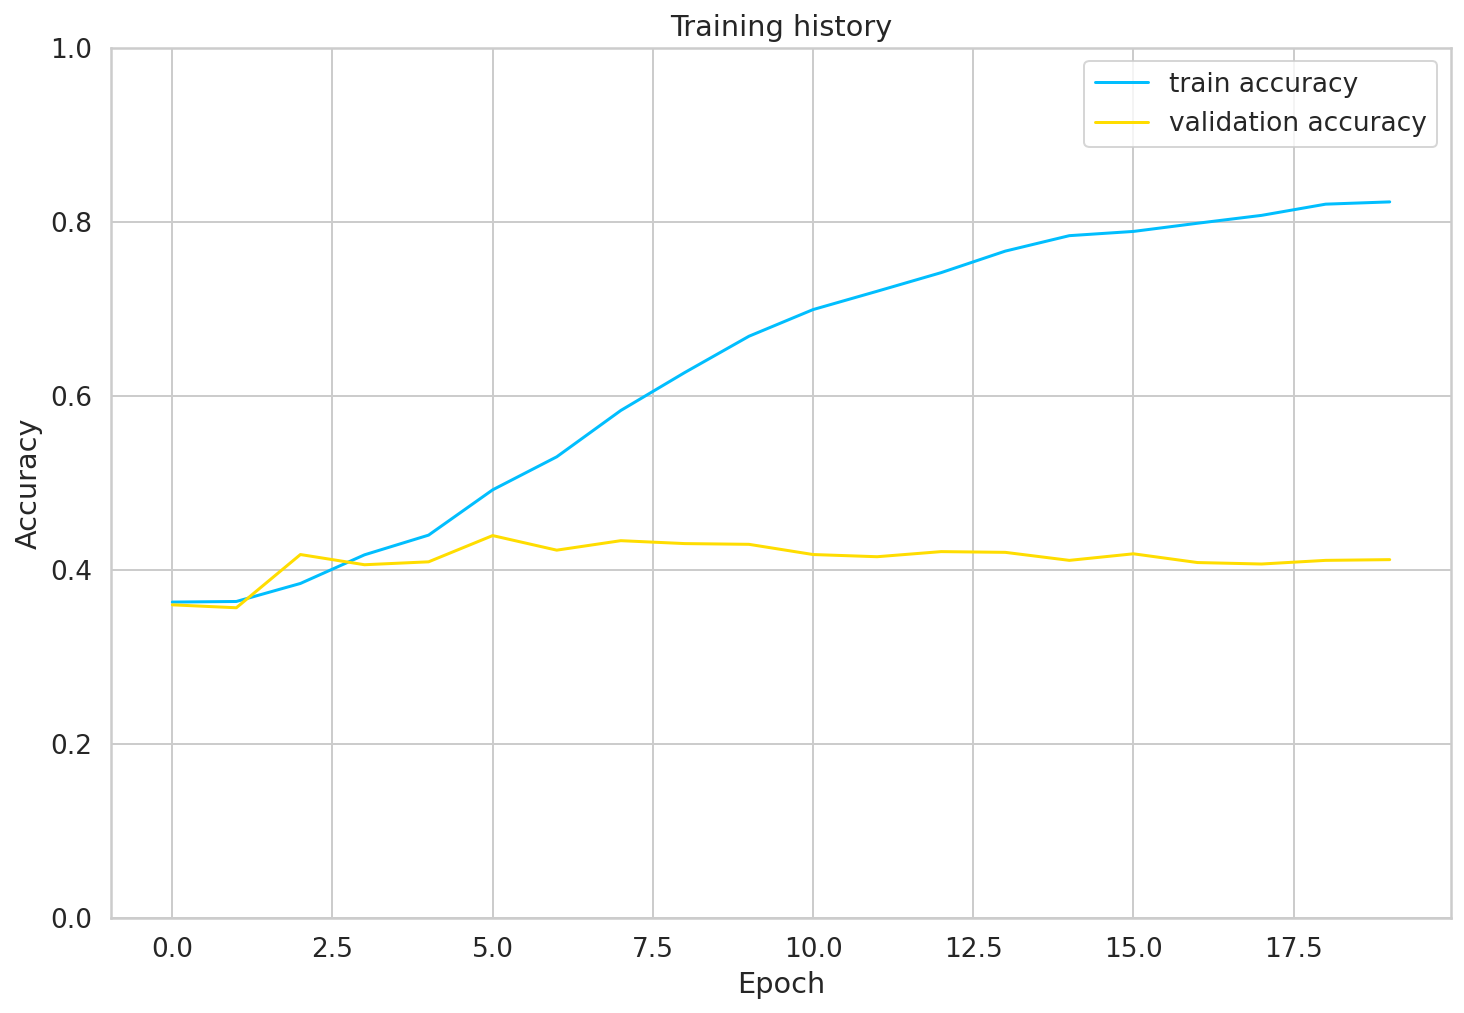

In [29]:
plt.plot([i.cpu() for i in history['train_acc']], label='train accuracy')
plt.plot([i.cpu() for i in history['val_acc']], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [30]:
# !gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA

model = SentimentClassifier(len(class_names))
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs")
    model = nn.DataParallel(model.cuda(), device_ids=[0, 1, 2, 3])
model = model.to(device)
model.load_state_dict(torch.load('Pretrained_RoBert_SRL(FC)_CL(V).bin'))

Some weights of the model checkpoint at /home/jovyan/graph-stock-pred/Astock/models/ROBERT_4_model were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at /home/jovyan/graph-stock-pred/Astock/models/ROBERT_4_model and are

Using 4 GPUs


<All keys matched successfully>

In [31]:
len(df_test)

1121

In [38]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.4380017841213203

In [39]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["titles"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      verb = d["verb"].to(device)
      A0 = d["A0"].to(device)
      A1 = d["A1"].to(device)
      AV_num = d['AV_num'].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        verb = verb,
        A0 = A0,
        A1 = A1,
        AV_num = AV_num
      )[0]
#       _, preds = torch.max(outputs, dim=1)
      
      if outputs.dim()==1:
        outputs = torch.unsqueeze(outputs,0)
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [40]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

              precision    recall  f1-score   support

    negative     0.4329    0.3568    0.3912       398
     neutral     0.4548    0.4371    0.4458       334
    positive     0.4301    0.5219    0.4715       389

    accuracy                         0.4380      1121
   macro avg     0.4393    0.4386    0.4362      1121
weighted avg     0.4385    0.4380    0.4353      1121



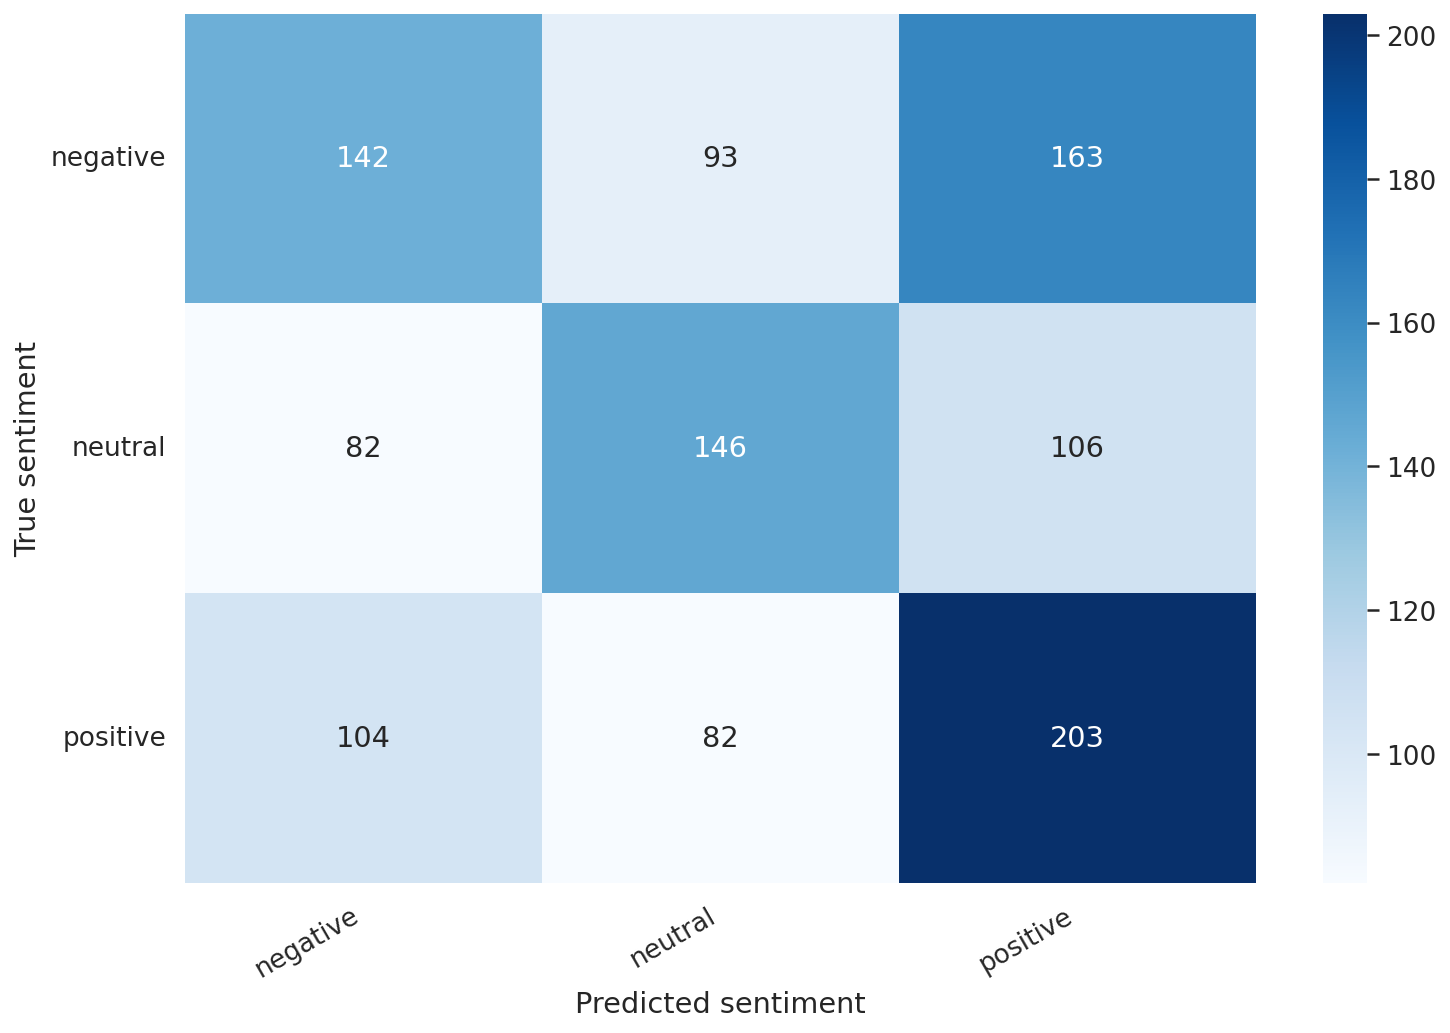

In [41]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

print(classification_report(y_test, y_pred, target_names=class_names,digits=4))

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

              precision    recall  f1-score   support

    negative     0.4306    0.4936    0.4599       622
     neutral     0.3849    0.3145    0.3462       585
    positive     0.4457    0.4570    0.4513       628

    accuracy                         0.4240      1835
   macro avg     0.4204    0.4217    0.4191      1835
weighted avg     0.4212    0.4240    0.4207      1835



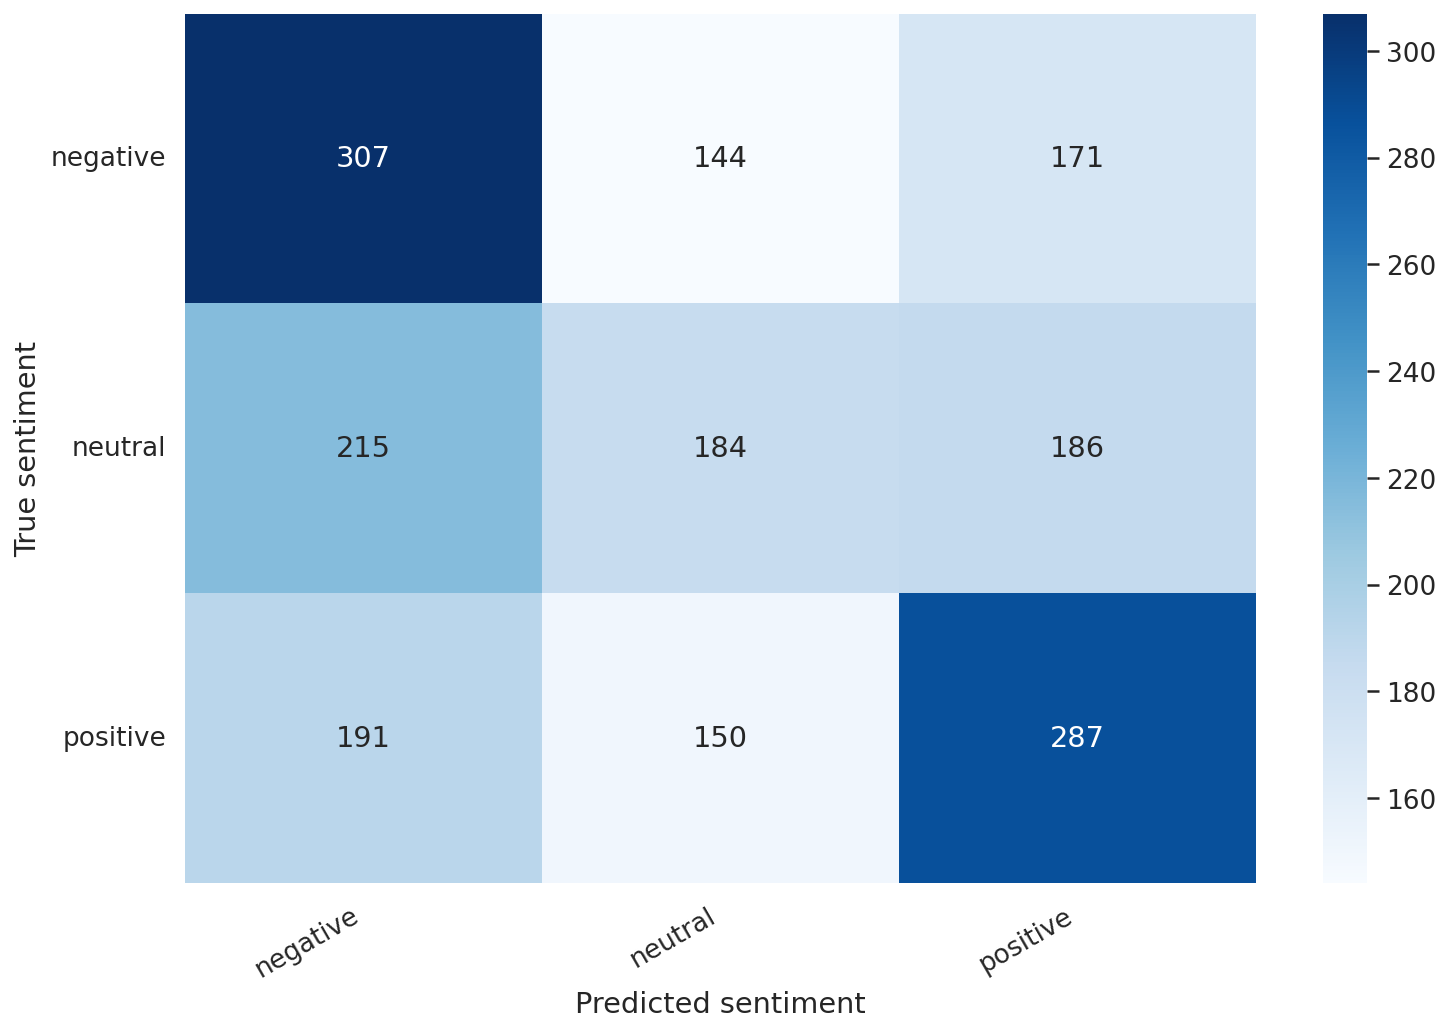

In [42]:
y_ood_review_texts, y_ood_pred, y_ood_pred_probs, y_ood = get_predictions(
  model,
  ood_data_loader
)

print(classification_report(y_ood, y_ood_pred, target_names=class_names,digits=4))

ood_cm = confusion_matrix(y_ood, y_ood_pred)
df_ood_cm = pd.DataFrame(ood_cm, index=class_names, columns=class_names)
show_confusion_matrix(df_ood_cm)

In [44]:
df = pd.DataFrame([y_ood_review_texts, y_ood_pred.numpy(), y_ood_pred_probs.numpy(), y_ood.numpy()]).T
df = df.rename(columns={0: 'text',1: 'prediction',2: 'probability',3: 'labels'})
df.to_csv('try_Pretrained_RoBert_SRL(FC)_V_ood_0.43.csv',sep='\t')